In [1]:
import os
import cv2
import numpy as np

# Đường dẫn gốc
base_path = '/kaggle/input/dataset265/UECFOOD256'

# Lưu ảnh cắt vào đây
output_path = '/kaggle/working/cropped_images'
os.makedirs(output_path, exist_ok=True)

# Duyệt qua từng folder món ăn
for folder_name in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder_name)
    bb_file = os.path.join(folder_path, 'bb_info.txt')
    
    if not os.path.isfile(bb_file):
        continue
    
    with open(bb_file, 'r') as f:
        lines = f.readlines()[1:]  # bỏ dòng tiêu đề
    
    for line in lines:
        img_name, x1, y1, x2, y2 = line.strip().split()
        img_path = os.path.join(folder_path, img_name + '.jpg')
        
        # Đọc ảnh
        image = cv2.imread(img_path)
        if image is None:
            continue
        
        # Cắt ảnh theo bbox
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        cropped = image[y1:y2, x1:x2]
        
        # Lưu ảnh cắt
        save_path = os.path.join(output_path, f'{folder_name}_{img_name}.jpg')
        cv2.imwrite(save_path, cropped)


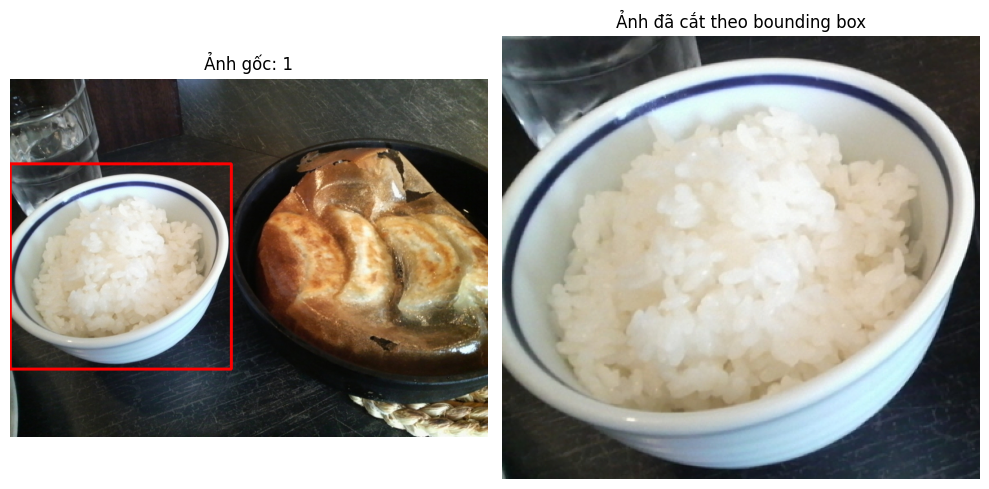

In [3]:
import matplotlib.pyplot as plt
# Đường dẫn đến folder 1
folder_path = '/kaggle/input/dataset265/UECFOOD256/1'
bb_file = os.path.join(folder_path, 'bb_info.txt')

# Đọc bb_info.txt
with open(bb_file, 'r') as f:
    lines = f.readlines()[1:]  # bỏ dòng tiêu đề

# Lấy 1 dòng đầu tiên
line = lines[0]
img_name, x1, y1, x2, y2 = line.strip().split()
img_path = os.path.join(folder_path, img_name + '.jpg')

# Đọc ảnh gốc
image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Hiển thị ảnh gốc có vẽ bounding box
x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
image_bbox = image_rgb.copy()
cv2.rectangle(image_bbox, (x1, y1), (x2, y2), (255, 0, 0), 3)  # vẽ bbox màu xanh dương

# Cắt ảnh
cropped = image_rgb[y1:y2, x1:x2]

# Hiển thị ảnh gốc và ảnh đã cắt
plt.figure(figsize=(10, 5))

# Ảnh gốc + bbox
plt.subplot(1, 2, 1)
plt.imshow(image_bbox)
plt.title(f'Ảnh gốc: {img_name}')
plt.axis('off')

# Ảnh cắt
plt.subplot(1, 2, 2)
plt.imshow(cropped)
plt.title('Ảnh đã cắt theo bounding box')
plt.axis('off')

plt.tight_layout()
plt.show()


In [58]:
import torch
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b4
from PIL import Image
from tqdm import tqdm

# Thiết bị
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load EfficientNet-B0 pretrained
model = efficientnet_b4(pretrained=True)
model.classifier = torch.nn.Identity()  # Bỏ lớp phân loại cuối
model = model.to(device)
model.eval()

# Transform ảnh
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Thư mục ảnh cắt
cropped_folder = '/kaggle/working/cropped_images'

# Mã hóa ảnh
feature_vectors = []
image_names = []

for img_name in tqdm(os.listdir(cropped_folder), desc='Encoding'):
    if not img_name.lower().endswith('.jpg'):
        continue
    img_path = os.path.join(cropped_folder, img_name)
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        vector = model(img_tensor).cpu().numpy().flatten()  # 1280 chiều

    feature_vectors.append(vector)
    image_names.append(img_name)

# Chuyển thành numpy array
feature_vectors = np.array(feature_vectors).astype('float32')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 170MB/s] 
Encoding: 100%|██████████| 31395/31395 [11:26<00:00, 45.76it/s]


In [59]:
import pickle
with open('/kaggle/working/feature_vectors.pkl', 'wb') as f:
    pickle.dump(feature_vectors, f)

In [60]:
# pip install faiss-gpu


In [61]:
import faiss

# Tạo index FAISS (cosine similarity)
d = feature_vectors.shape[1]  # 1280
index = faiss.IndexFlatIP(d)

# Chuẩn hóa vector (cosine similarity cần normalize)
faiss.normalize_L2(feature_vectors)

# Thêm vector vào index
index.add(feature_vectors)

# Tìm kiếm: lấy vector của ảnh đầu tiên để test
query_vector = feature_vectors[2].reshape(1, -1)

# Tìm 5 ảnh tương đồng nhất
D, I = index.search(query_vector, k=5)

# Hiển thị kết quả
print("Ảnh query:", image_names[0])
print("Top 5 ảnh tương đồng:")
for idx in I[0]:
    print(f" - {image_names[idx]}")


Ảnh query: 124_185870.jpg
Top 5 ảnh tương đồng:
 - 211_204395.jpg
 - 243_323271.jpg
 - 204_312068.jpg
 - 27_2625.jpg
 - 211_204081.jpg


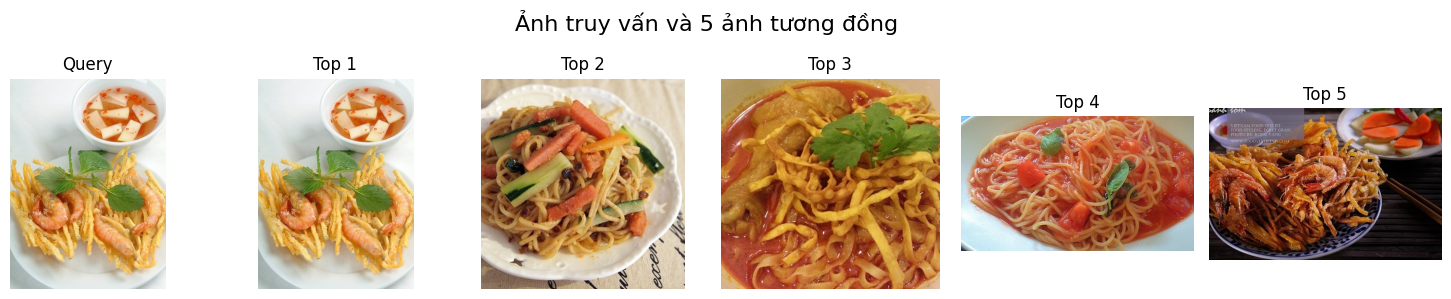

In [62]:
import matplotlib.pyplot as plt
from PIL import Image

# Folder chứa ảnh đã cắt
cropped_folder = '/kaggle/working/cropped_images'

# Ảnh truy vấn
query_idx = 2  # Lấy ảnh đầu tiên làm query
query_name = image_names[query_idx]

# Top 5 ảnh tương đồng
top_indices = I[0]  # từ kết quả index.search
top_image_names = [image_names[idx] for idx in top_indices]

# Hiển thị ảnh truy vấn
plt.figure(figsize=(15, 3))
plt.subplot(1, 6, 1)
img_query = Image.open(os.path.join(cropped_folder, query_name))
plt.imshow(img_query)
plt.title('Query')
plt.axis('off')

# Hiển thị 5 ảnh tương đồng
for i, img_name in enumerate(top_image_names):
    img = Image.open(os.path.join(cropped_folder, img_name))
    plt.subplot(1, 6, i + 2)
    plt.imshow(img)
    plt.title(f"Top {i+1}")
    plt.axis('off')

plt.suptitle("Ảnh truy vấn và 5 ảnh tương đồng", fontsize=16)
plt.tight_layout()
plt.show()


In [63]:
# Tạo danh sách label từ tên ảnh
labels = []
for img_name in image_names:
    label = int(img_name.split('_')[0])  # Ví dụ: '10_2.jpg' → 10
    labels.append(label)
labels = np.array(labels)


In [64]:
labels

array([124,   7, 211, ...,  54,  86, 229])

In [65]:


# Chuẩn hóa vector (cosine similarity)
# faiss.normalize_L2(feature_vectors)

# Tạo index và add vector
d = feature_vectors.shape[1]
index = faiss.IndexFlatIP(d)
index.add(feature_vectors)


In [57]:
top1_correct = 0
top5_correct = 0
total = len(feature_vectors)

# Tìm kiếm tất cả ảnh với FAISS
D, I = index.search(feature_vectors, k=6)

for i in range(total):
    query_label = labels[i]
    retrieved_labels = labels[I[i]]  # label của top-5 kết quả
    
    if retrieved_labels[0] == query_label:
        top1_correct += 1
    for finding_label in retrieved_labels:    
        if query_label == finding_label:
            top5_correct += 1

# Tính accuracy
top1_acc = top1_correct / total
top5_acc = (top5_correct-total) / (total*5)

print(f"Top-1 Accuracy: {top1_acc:.4f}")
print(f"Top-5 Accuracy: {top5_acc:.4f}")


Top-1 Accuracy: 1.0000
Top-5 Accuracy: 0.4115


In [71]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import faiss

def encode_and_evaluate_model(model_name, cropped_folder='/kaggle/working/cropped_images'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 1. Load model + transform theo tên model
    if model_name == 'efficientnet_b0':
        from torchvision.models import efficientnet_b0
        model = efficientnet_b0(pretrained=True)
        model.classifier = torch.nn.Identity()
        transform = transforms.Compose([
            transforms.Resize(256), transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
    
    elif model_name == 'efficientnet_b3':
        from torchvision.models import efficientnet_b3
        model = efficientnet_b3(pretrained=True)
        model.classifier = torch.nn.Identity()
        transform = transforms.Compose([
            transforms.Resize(256), transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
    
    elif model_name == 'resnet50':
        from torchvision.models import resnet50
        model = resnet50(pretrained=True)
        model.fc = torch.nn.Identity()
        transform = transforms.Compose([
            transforms.Resize(256), transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
    
    elif model_name == 'clip_vit_b32':
        import clip
        model, transform = clip.load("ViT-B/32", device=device)
    
    else:
        raise ValueError("Model không hỗ trợ")

    model = model.to(device)
    model.eval()

    # 2. Encode ảnh
    feature_vectors = []
    image_names = []

    for img_name in tqdm(os.listdir(cropped_folder), desc=f'Encoding with {model_name}'):
        if not img_name.lower().endswith('.jpg'):
            continue
        img_path = os.path.join(cropped_folder, img_name)
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            if model_name.startswith('clip'):
                vector = model.encode_image(img_tensor).cpu().numpy().flatten()
            else:
                vector = model(img_tensor).cpu().numpy().flatten()
        
        feature_vectors.append(vector)
        image_names.append(img_name)

    feature_vectors = np.array(feature_vectors).astype('float32')
    labels = np.array([int(name.split('_')[0]) for name in image_names])

    # 3. FAISS tìm kiếm
    faiss.normalize_L2(feature_vectors)
    d = feature_vectors.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(feature_vectors)
    D, I = index.search(feature_vectors, k=5)

    # 4. Đánh giá accuracy
    top1_correct = 0
    top5_correct = 0
    total = len(feature_vectors)
    for i in range(total):
        query_label = labels[i]
        retrieved_labels = labels[I[i]]  # label của top-5 kết quả
        
        if retrieved_labels[0] == query_label:
            top1_correct += 1
        for finding_label in retrieved_labels:    
            if query_label == finding_label:
                top5_correct += 1
    
    # Tính accuracy
    top1_acc = top1_correct / total
    top5_acc = (top5_correct-total) / (total*5)

    print(f"\n--- Kết quả model: {model_name} ---")
    print(f"Số ảnh: {total} | Vector chiều: {d}")
    print(f"Top-1 Accuracy: {top1_acc:.4f}")
    print(f"Top-5 Accuracy: {top5_acc:.4f}")

    return {
        'model': model_name,
        'top1_acc': top1_acc,
        'top5_acc': top5_acc,
        'vector_dim': d,
        'num_images': total,
    }


In [ ]:
encode_and_evaluate_model('efficientnet_b0')
encode_and_evaluate_model('efficientnet_b3')
encode_and_evaluate_model('resnet50')
encode_and_evaluate_model('clip_vit_b32')


Encoding with efficientnet_b0:  24%|██▎       | 7456/31395 [01:39<05:03, 78.79it/s]